In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parents[1]))
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 引言

自 1993 年 Jegadeesh 和 Titman 提出并证明动量效应以来, 动量策略被广泛研究与应用。随着高频数据可获得性的增加以及相关技术的进步, 对动量效应的研究也逐渐拓展到日内领域，并被证明同样存在。

学术界对动量效应存在的原因至今仍有诸多争议, 但较有说服力的解释之一是价格对新信息的反应不足。即, 需要一定的时间逐步消化和反应新信息, 从而形成动量。造成反应不足的原因可能有,

1. 处置效应, 即卖出盈利头寸而继续持有亏损头寸。这种行为产生的资金流动可能会减缓利好（利空）消息后，股价的抬升（下跌）速度。

2. 投资者的注意力有限, 或是获取信息的成本较高。

3. 无法快速交易导致价格发现的速度变慢。

Zarattini C, Aziz A 和 Barbon A 在论文《Beat the Market: An Effective Intraday Momentum Strategy for S&P500 ETF (SPY)》中介绍了一种由粘性供需失衡（sticky demand/supply imbalances) 引起的日内动量效应, 并以此为基础, 设计了一个简洁而明确的 ETF 交易策略。本文参考其逻辑，对上证 50、沪深 300、中证 500、中证 1000 进行测试, 发现了相同的规律。

# 数据获取

In [2]:
etf_price: pd.DataFrame = pd.read_parquet("dataset/etf/hfq_etf_minute_price.parquet")

index_price: pd.DataFrame = pd.read_parquet("dataset/index/index_minute_price.parquet")

# 信号构造


## 噪声区域

日内动量策略通常源自买卖双方的力量在一段时间内, 存在持续且显著的不平衡。但由于股票市场的噪声水平较高, 故我们需要定义一个买卖双方力量平衡时, 价格的正常波动区域, 并称之为噪声区域。若价格在噪声区域中波动, 则认为不存在日内趋势。

一种合理的假设是, 当日内走势接近过去若干天相同时间段的平均走势, 则可以认为市场处于供需平衡状态。由此，我们可按如下步骤定义 $\mathrm{t}$ 日的噪声区域。

1. 计算过去 14 天每个分钟时点 hh:mm 的价格位移 (相对开盘价的收益率绝对值):

$$
{\text{ move }}_{t - i,9 : {30} \sim {hh} : {mm}} = \left| {\frac{{\text{ close }}_{t - i,{hh} : {mm}}}{{\text{ open }}_{t - i,9 : {30}}} - 1}\right| ,\;i = 1 \sim {14}
$$

2. 取过去 14 天 hh:mm 时点的位移平均值:

$$
{\sigma }_{t - i,9 : {30} \sim {hh} : {mm}} = \frac{1}{14}\mathop{\sum }\limits_{{i = 1}}^{{14}}{\text{ move }}_{t - i,9 : {30} \sim {hh} : {mm}}
$$

3. 考虑到隔夜跳空缺口往往也预示着某种供需失衡, 因此进一步结合昨收盘价, 将 $\mathrm{t}$ 日 hh:mm 时点的噪声区域的上、下边界分别定义为:

$$
{\text{ UpperBound }}_{t,{hh} : {mm}} = \max \left( {{\text{ open }}_{t,9 : {30}},{\text{ close }}_{t - 1,{15} : {00}}}\right) * \left( {1 + {\sigma }_{t - i,9 : {30} \sim {hh} : {mm}}}\right)
$$

$${\text{ LowerBound }}_{t,{hh} : {mm}} = \min \left( {{\text{ open }}_{t,9 : {30}},{\text{ close }}_{t - 1,{15} : {00}}}\right) * \left( {1 - {\sigma }_{t - i,9 : {30} \sim {hh} : {mm}}}\right)$$

4. 则 $\mathrm{t}$ 日 hh:mm 时点的噪声区域为:

$$
{\text{NoiseArea}}_{t,{hh} : {mm}} = \left\lbrack {{\text{LowerBound}}_{t,{hh} : {mm}},{\text{UpperBound}}_{t,{hh} : {mm}}}\right\rbrack
$$

如果此时的价格位于噪声区域内, 则说明供需处于平衡状态; 当价格突破噪声区域的上边界, 说明存在大量买入需求, 价格可能进一步上升; 当价格突破噪声区域的下边界, 说明存在大量抛售压力, 价格可能进一步下降。

In [3]:
from src.SignalMaker import NoiseArea

In [4]:
etf_price.head()

,trade_time,code,open,high,low,close,volume,amount
0,2013-10-08 09:30:00,510050.SH,1.928290,1.928290,1.928290,1.928290,1152800.0,1948232.0
1,2013-10-08 09:30:00,510300.SH,2.476188,2.476188,2.476188,2.476188,224101.0,547255.0
2,2013-10-08 09:30:00,510500.SH,1.099000,1.099000,1.099000,1.099000,0.0,0.0
3,2013-10-08 09:31:00,510500.SH,1.096000,1.096000,1.089000,1.096000,364800.0,399734.0
4,2013-10-08 09:31:00,510300.SH,2.486328,2.486328,2.476188,2.485314,1066494.0,2611913.0


In [5]:
index_price.head()

,trade_time,code,close,open,high,low,volume,amount
0,2013-10-08 09:30:00,000016.SH,1637.975,1637.9750,1637.9750,1637.9750,23522400.0,1.514756e+08
1,2013-10-08 09:30:00,000300.SH,2406.415,2406.4150,2406.4150,2406.4150,77130500.0,7.254123e+08
2,2013-10-08 09:30:00,000905.SH,3875.522,3875.5220,3875.5220,3875.5220,37016000.0,3.676665e+08
3,2013-10-08 09:31:00,000300.SH,2399.630,2403.9661,2403.9661,2399.5911,127033500.0,1.068587e+09
4,2013-10-08 09:31:00,000016.SH,1632.459,1636.1470,1636.1470,1632.2679,59359400.0,3.609640e+08


In [6]:
# 使用etf分钟数据生成信号
etf_signal: pd.DataFrame = NoiseArea(etf_price).fit(14)
# 使用指数分钟数据生成信号
index_signal: pd.DataFrame = NoiseArea(index_price).fit(14)

使用指数生成信号，在对应的etf上进行交易

In [7]:
etf_codes: List[str] = ["510300.SH", "510050.SH", "510500.SH", "159845.SZ"]
index_codes: List[str] = ["000300.SH", "000016.SH", "000905.SH", "000852.SH"]

ohlcv: pd.DataFrame = index_price.copy()
ohlcv["code"] = ohlcv["code"].map(dict(zip(index_codes, etf_codes)))

# 信号拼接
combo_data: pd.DataFrame = NoiseArea(ohlcv).concat_signal(etf_price)
combo_data.set_index("trade_time", inplace=True)

In [8]:
combo_data.head()

,code,open,high,low,close,volume,amount,upperbound,signal,lowerbound,vwap
trade_time,,,,,,,,,,,
2013-10-08 09:30:00,510050.SH,1.928290,1.928290,1.928290,1.928290,1152800.0,1948232.0,NaN,1637.975,NaN,1637.975000
2013-10-08 09:30:00,510300.SH,2.476188,2.476188,2.476188,2.476188,224101.0,547255.0,NaN,2406.415,NaN,2406.415000
2013-10-08 09:30:00,510500.SH,1.099000,1.099000,1.099000,1.099000,0.0,0.0,NaN,3875.522,NaN,3875.522000
2013-10-08 09:31:00,510050.SH,1.926008,1.929431,1.922585,1.922585,6658217.0,11235951.0,NaN,1632.459,NaN,1634.024477
2013-10-08 09:31:00,510300.SH,2.486328,2.486328,2.476188,2.485314,1066494.0,2611913.0,NaN,2399.630,NaN,2402.193285


# 基础策略

我们以分钟K线的收盘价突破噪声区域边界作为开仓信号。具体地,当收盘价在噪声区域内, 认为是合理波动, 不存在趋势, 无信号; 当收盘价在噪声区域上边界 (UpperBound) 上方, 认为向上趋势形成, 发出做多信号, 并以下一分钟的开盘价开多仓; 当收盘价在噪声区域下边界 (LowerBound) 下方, 认为向下趋势形成, 发出做空信号, 并以下一分钟的开盘价开空仓。

由于是日内的动量策略,我们不持仓过夜,因此设定如下的平仓规则。当分钟K线的收盘价突破当前仓位的对向边界或是当日收盘, 则平仓。具体地, 若当前是多头仓位, 而价格突破噪声区域下边界 (LowerBound), 以下一分钟开盘价平仓; 若价格一直在下边界之上，以当日收盘价平仓。反之，若当前是空头仓位，而价格突破噪声区域上边界 (UpperBound), 以下一分钟开盘价平仓; 若价格一直在上边界之下, 以当日收盘价平仓。

为避免价格在噪声边界附近震荡时,信号过于频繁。我们规定,仅在 1 小时K线,即每日的 10:29、11:29、13:59，三个时点上，判断是否开仓。不过，为了及时止损，一旦在收盘前触发平仓信号, 则立即以下一分钟的开盘价平仓。

In [9]:
from src.bt_template import run_template_strategy
from src.plotting import plot_cumulative_return, plot_intraday_signal
from src.strategy import NoiseRangeStrategy
from src.utils import get_strategy_cumulative_return, trans_minute_to_daily

/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


这里展示的是沪深300指数在2013-10-25的分钟信号情况

<Axes: title={'center': 'Signal on 2013-10-25'}, xlabel='trade_time'>

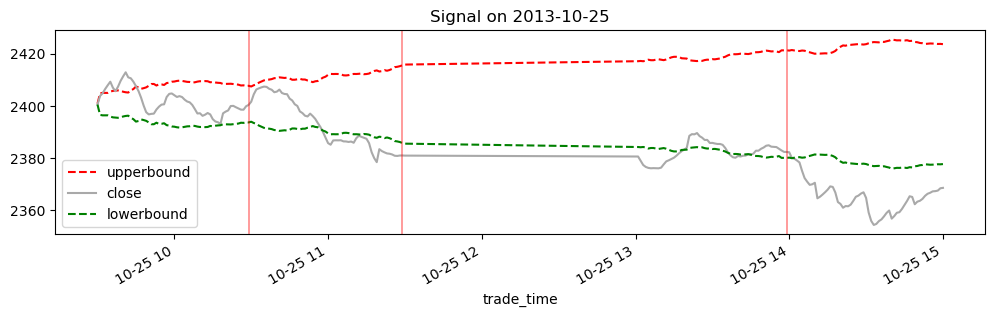

In [10]:
plot_intraday_signal(combo_data.query('code=="510300.SH"'), "2013-10-25")

**所有回测均收取万一的手续费及万一点五的印花税及万一的滑点。且只能以100的正数倍买入标的**

In [11]:
target_code: str = "510300.SH"
noiserange_strat = run_template_strategy(
    combo_data, target_code, NoiseRangeStrategy, strategy_kwargs={"verbose": False}
)

2024-08-21 10:50:52.982 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 10:50:53.087 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！


<Axes: title={'center': 'NoiseRangeStrategy'}, xlabel='trade_time'>

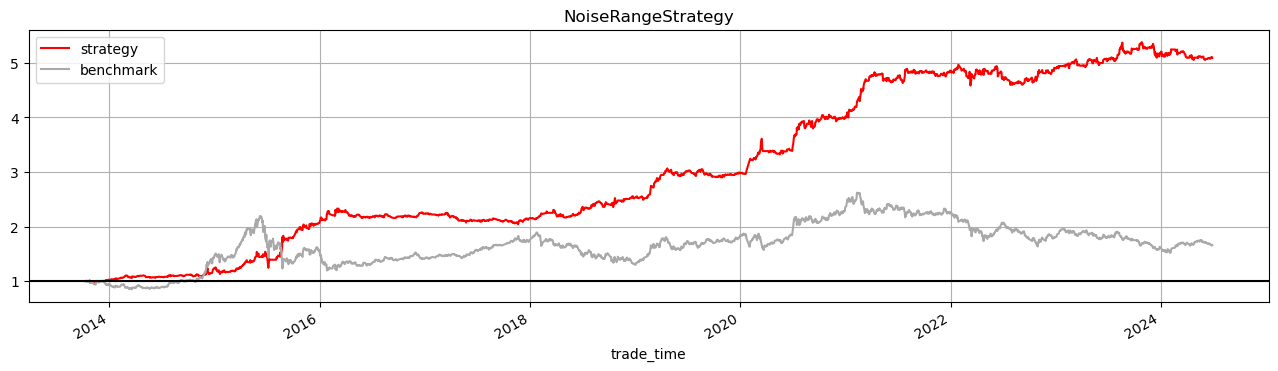

In [12]:
plot_cumulative_return(
    noiserange_strat,
    combo_data.query("code==@target_code")["close"],
    title="NoiseRangeStrategy",
)

# 改进策略1：调整止损规则

虽然全区间内, 策略效果颇佳, 但在某些市场状态下, 却也容易面临较大的单日亏损。

因此, 我们考虑设置更严格的止损规则, 而最直接的方法就是将同向边界作为止损线。 即，做多（空）时价格回到上（下）边界时平仓。另一方面，有诸多研究表明，成交量加权平均价格 (VWAP) 也是一个有效的识别日内供需平衡变化的指标。因此, 我们将其与噪声区域的边界结合, 得到最终的止损线。

做多时, 止损线为上边界和 VWAP 两者的较大值。即,

$$
\max \left( {{\text{ UpperBound }}_{t,{hh} : {mm}},{\text{ VWAP }}_{t,{hh} : {mm}}}\right)
$$

做空时, 止损线为下边界和 VWAP 两者的较小值。即,

$$
\min \left( {{\text{ LowerBound }}_{t,{hh} : {mm}},{VWA}{P}_{t,{hh} : {mm}}}\right)
$$


In [13]:
from src.strategy import NoiseRangeVWAPStrategy

In [14]:
noisevwaprange_strat = run_template_strategy(
    combo_data, target_code, NoiseRangeVWAPStrategy, strategy_kwargs={"verbose": False}
)

2024-08-21 10:52:42.257 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 10:52:42.397 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！


<Axes: title={'center': 'NoiseRangeVWAPStrategy'}, xlabel='trade_time'>

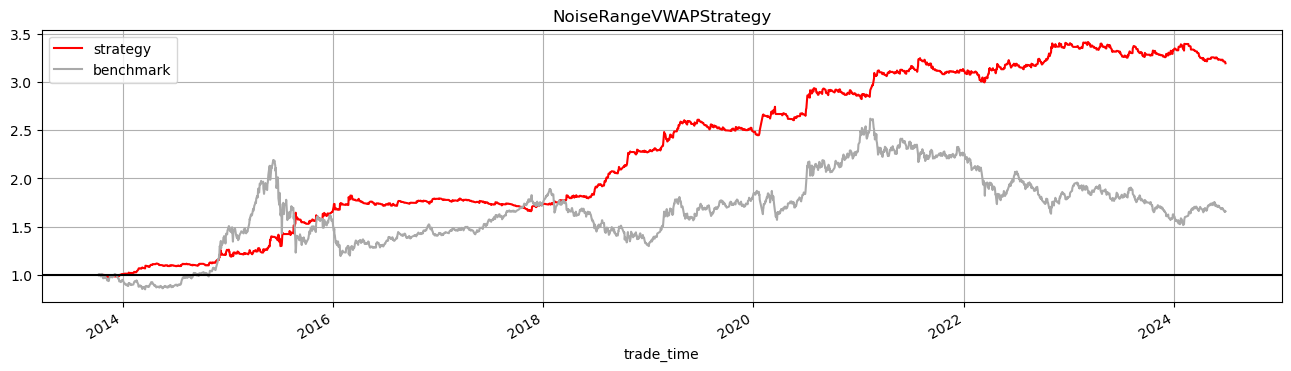

In [15]:
plot_cumulative_return(
    noisevwaprange_strat,
    combo_data.query("code==@target_code")["close"],
    title="NoiseRangeVWAPStrategy",
)

## 对比基础策略与改进策略

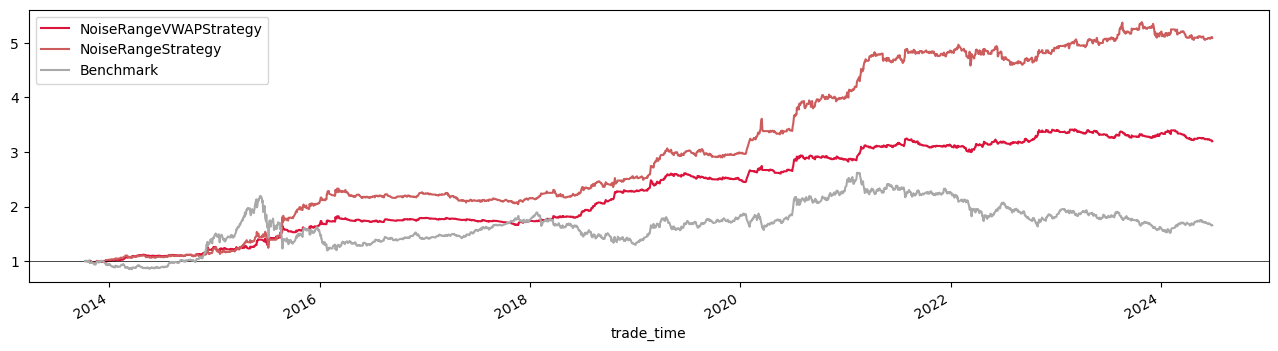

In [16]:
noisevwaprange_returns: pd.Series = get_strategy_cumulative_return(
    noisevwaprange_strat, 1
)
noiserange_returns: pd.Series = get_strategy_cumulative_return(noiserange_strat, 1)

noisevwaprange_returns.plot(
    label="NoiseRangeVWAPStrategy", figsize=(16, 4), color="Crimson"
)
noiserange_returns.plot(label="NoiseRangeStrategy", color="IndianRed").axhline(
    1, color="black", lw=0.5
)
daily_close: pd.Series = trans_minute_to_daily(
    combo_data.query("code==@target_code")["close"]
)

(daily_close / daily_close.iloc[0]).plot(label="Benchmark", color="darkgray")
plt.legend()

# 有底仓的ETF日内动量策略

假设底仓仓位为50% ,当策略发出做多信号时,用剩余的50%仓位买入 ETF 至平仓信号触发或收盘, 再行卖出; 当策略发出做空信号时, 卖出已有的50%仓位至平仓信号触发或收盘，再买入 ETF，回到 50%仓位。即，日间始终保持仓位不变，试图通过日内交易相对买入持有 ETF 产生增强。由于该模式下无法使用杠杆, 因此我们只测试改进策略 1 。 此外, 日内完成一次交易后, 持有的均是当日买入的仓位, 无法再行交易, 故回测时只取每天的第一个信号, 交易成本同样设为单边万一。

In [17]:
from src.strategy import BasePositionStrategt

In [18]:
bp_strat = run_template_strategy(
    combo_data,
    target_code,
    BasePositionStrategt,
    strategy_kwargs={"verbose": False},
)

2024-08-21 10:54:34.290 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 10:54:34.441 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！


<Axes: title={'center': 'BasePositionStrategt'}, xlabel='trade_time'>

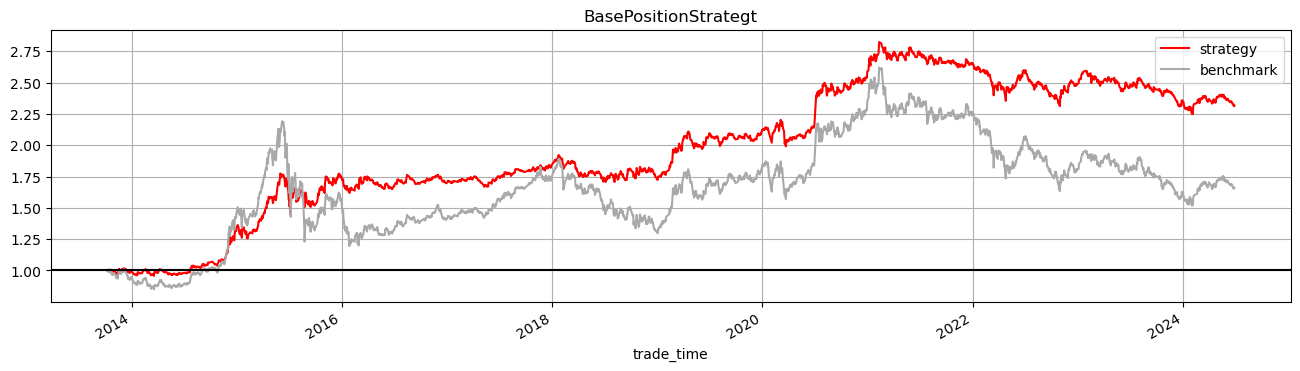

In [19]:
plot_cumulative_return(
    bp_strat,
    combo_data.query("code==@target_code")["close"],
    title="BasePositionStrategt",
)

## 多标的下的底仓策略

这里使用多个标的执行有底仓的ETF动量策略,每个标的等权持仓，独立执行策略。

In [20]:
hold_num: int = len(etf_codes)

multi_asset_strat = run_template_strategy(
    combo_data,
    etf_codes,
    BasePositionStrategt,
    strategy_kwargs={"verbose": False, "hold_num": hold_num},
)

2024-08-21 10:56:30.175 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-21 10:56:30.680 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！


<Axes: title={'center': 'BasePositionStrategt'}, xlabel='trade_time'>

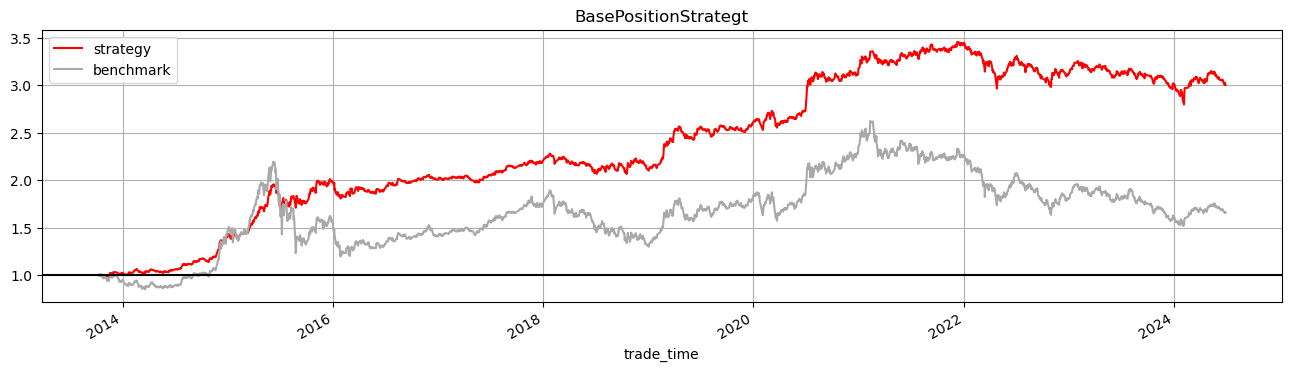

In [21]:
plot_cumulative_return(
    multi_asset_strat,
    combo_data.query("code==@target_code")["close"],
    title="BasePositionStrategt",
)

# 查看不同标的在不同策略下的表现情况

## 有底仓ETF策略下不同标的的表现

In [22]:
from src.performance import multi_asset_show_perf_stats,multi_strategy_show_perf_stats

In [23]:
multi_asset_dict: Dict = {
    code: run_template_strategy(
        combo_data,
        code,
        BasePositionStrategt,
        strategy_kwargs={"verbose": False, "hold_num": 1},
    )
    for code in etf_codes
}

2024-08-21 11:01:12.892 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:01:13.034 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:03:07.549 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:03:07.694 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:05:04.069 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:05:04.212 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:06:58.784 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:06:58.828 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！


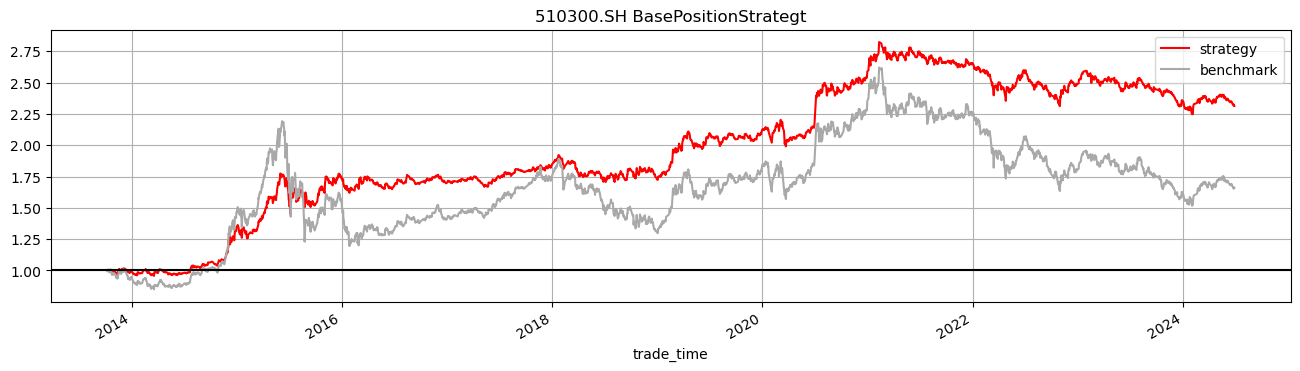

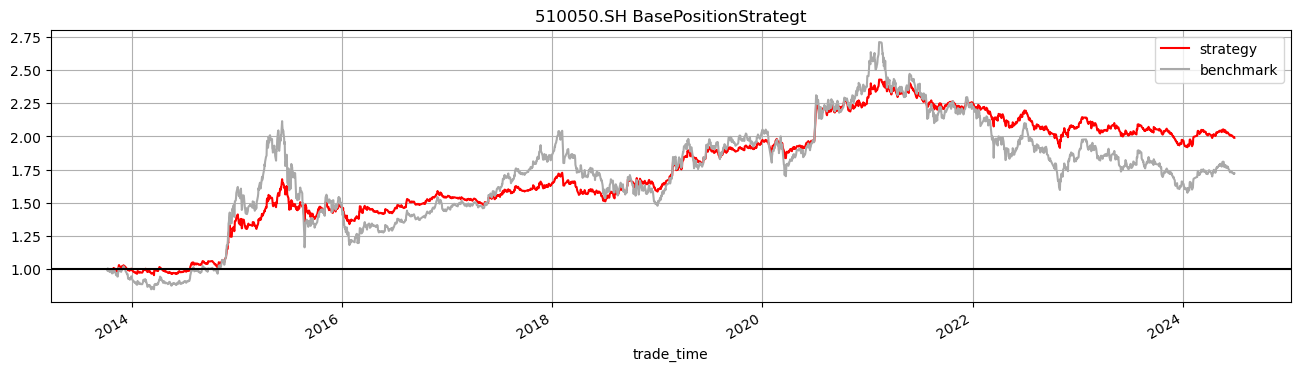

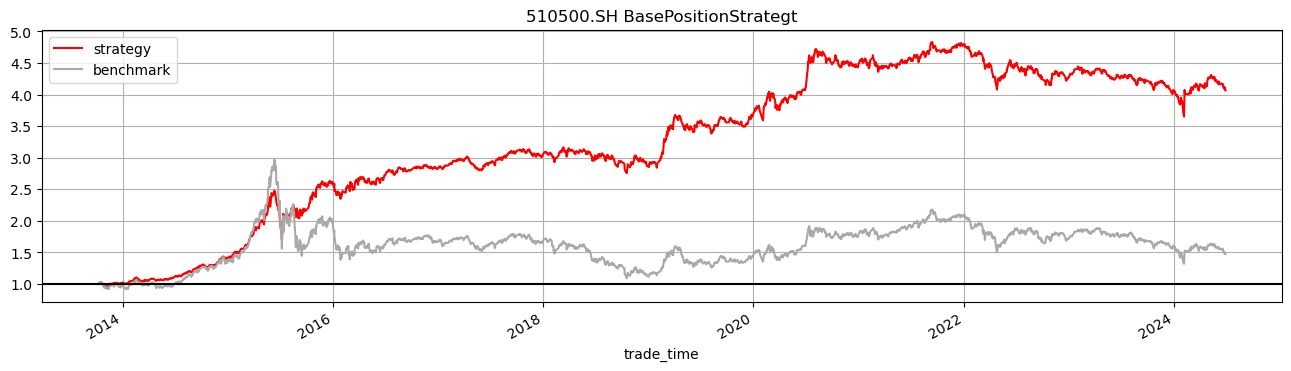

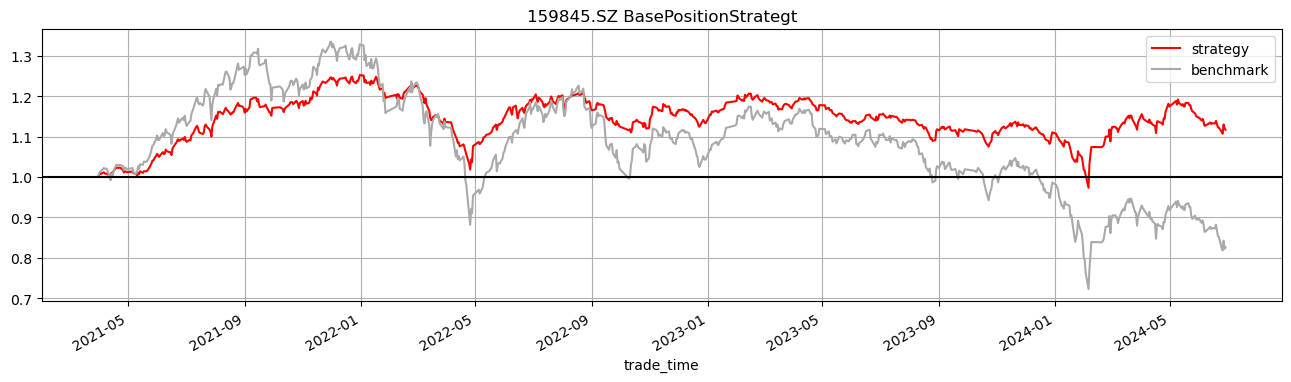

In [24]:
for code, strat in multi_asset_dict.items():
    plot_cumulative_return(
        strat,
        combo_data.query("code==@code")["close"],
        title=f"{code} BasePositionStrategt",
    )

In [25]:
multi_asset_show_perf_stats(multi_asset_dict,combo_data)

/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.478%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.898%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.587%' has dtype incompatible with floa

,510300.SH,510050.SH,510500.SH,159845.SZ
,Backtest,Backtest,Backtest,Backtest
Annual return,8.478%,6.898%,14.587%,3.602%
Cumulative returns,131.467%,98.97%,306.609%,11.687%
Annual volatility,12.899%,12.926%,14.818%,11.561%
Sharpe ratio,0.695037,0.580156,0.992573,0.36353
Calmar ratio,0.416129,0.325186,0.465718,0.161611
Stability,0.806353,0.787233,0.767297,0.000868
Max drawdown,-20.373%,-21.213%,-31.321%,-22.291%
Omega ratio,1.147,1.123363,1.218351,1.065495
Sortino ratio,1.177381,1.005646,1.680749,0.594393


## 不同策略下的标的表现

In [26]:
strategys: List = [NoiseRangeStrategy, NoiseRangeVWAPStrategy, BasePositionStrategt]
multi_strategy_dict: Dict = {
    code: {
        s.__name__: run_template_strategy(
            combo_data,
            code,
            s,
            strategy_kwargs={"verbose": False, "hold_num": 1},
        )
        for s in strategys
    }
    for code in etf_codes
}

2024-08-21 11:07:35.443 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:07:35.583 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:09:24.926 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:09:25.069 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:11:16.460 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:11:16.606 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:13:12.135 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:13:12.288 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:14:58.987 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:14:59.138 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:16:51.409 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:16:51.561 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:18:48.492 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:18:48.637 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:20:35.234 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:20:35.371 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:22:28.051 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:22:28.198 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:24:20.102 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:24:20.149 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:24:52.425 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:24:52.469 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！
2024-08-21 11:25:30.807 | INFO     | src.engine:load_data:119 - 开始加载数据...


数据加载到回测引擎...:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-21 11:25:30.852 | SUCCESS  | src.engine:load_data:134 - 数据加载完毕！


### 沪深300ETF

In [27]:
code:str = "510300.SH"

multi_strategy_show_perf_stats(multi_strategy_dict[code],combo_data)

/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.088%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.925%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.478%' has dtype incompatible with flo

,NoiseRangeStrategy,NoiseRangeVWAPStrategy,BasePositionStrategt
,Backtest,Backtest,Backtest
Annual return,17.088%,11.925%,8.478%
Cumulative returns,408.867%,219.593%,131.467%
Annual volatility,13.764%,9.755%,12.899%
Sharpe ratio,1.214926,1.20328,0.695037
Calmar ratio,0.894585,1.334872,0.416129
Stability,0.938345,0.935783,0.806353
Max drawdown,-19.102%,-8.933%,-20.373%
Omega ratio,1.355958,1.397483,1.147
Sortino ratio,1.998399,2.490129,1.177381


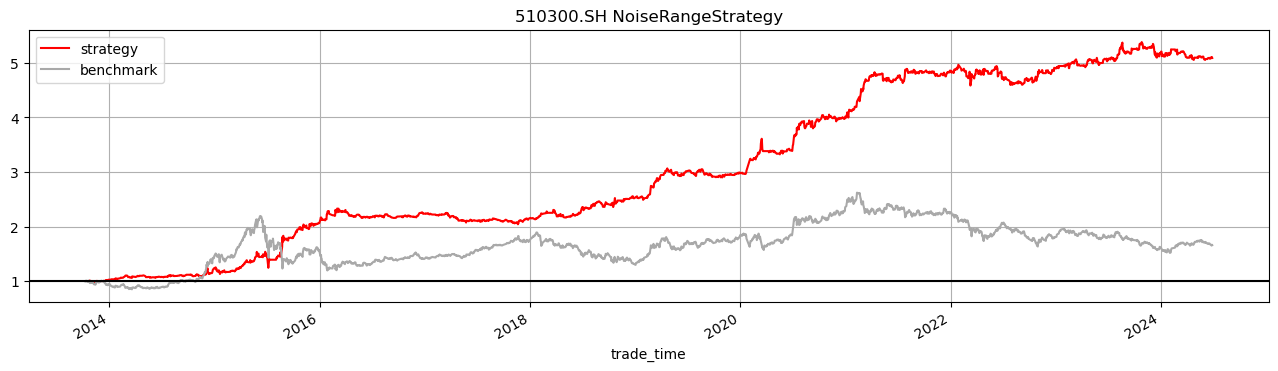

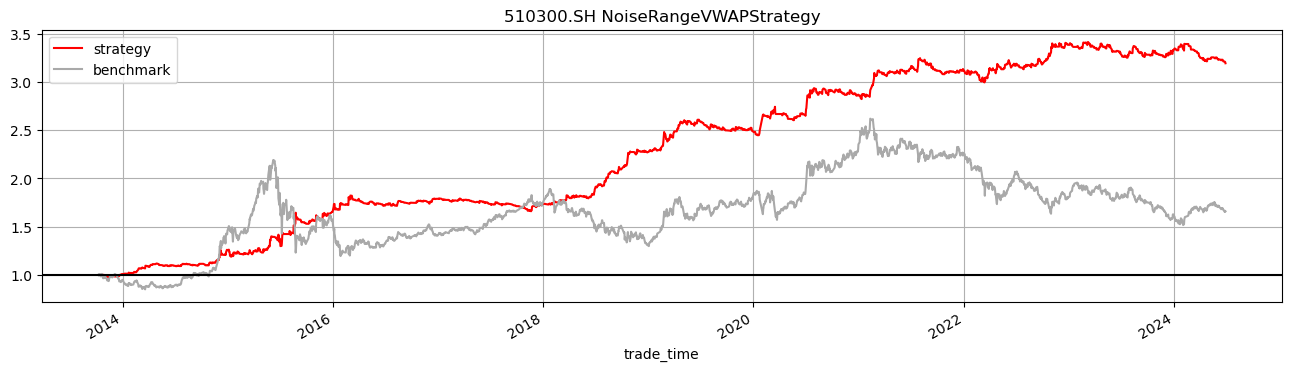

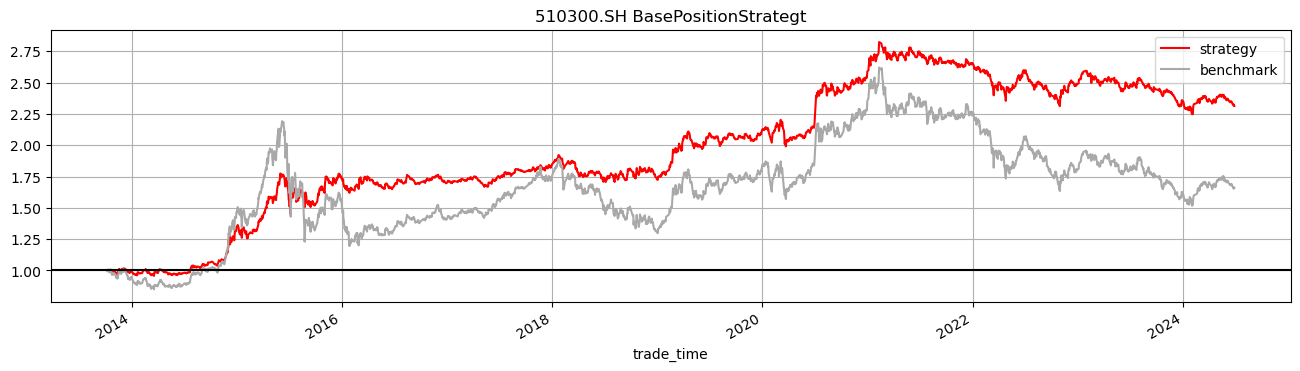

In [28]:
for strategy_name, strat in multi_strategy_dict[code].items():
    plot_cumulative_return(
        strat,
        combo_data.query("code==@code")["close"],
        title=f"{code} {strategy_name}",
    )

### 中证500ETF

In [29]:
code:str = "510500.SH"

multi_strategy_show_perf_stats(multi_strategy_dict[code],combo_data)

/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.452%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.278%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.587%' has dtype incompatible with fl

,NoiseRangeStrategy,NoiseRangeVWAPStrategy,BasePositionStrategt
,Backtest,Backtest,Backtest
Annual return,28.452%,23.278%,14.587%
Cumulative returns,1218.874%,763.538%,306.609%
Annual volatility,16.89%,11.936%,14.818%
Sharpe ratio,1.567557,1.812455,0.992573
Calmar ratio,1.582224,1.976939,0.465718
Stability,0.846386,0.878077,0.767297
Max drawdown,-17.982%,-11.775%,-31.321%
Omega ratio,1.515821,1.723733,1.218351
Sortino ratio,2.536442,4.271092,1.680749


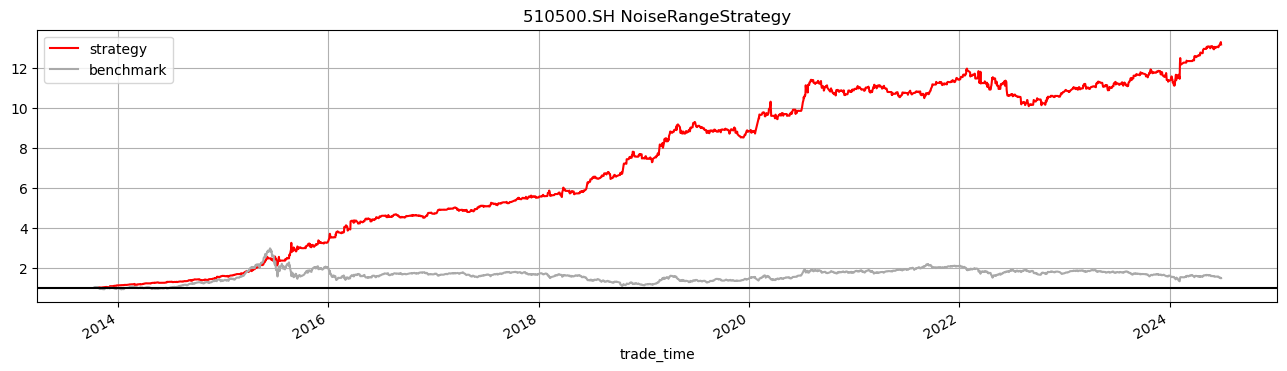

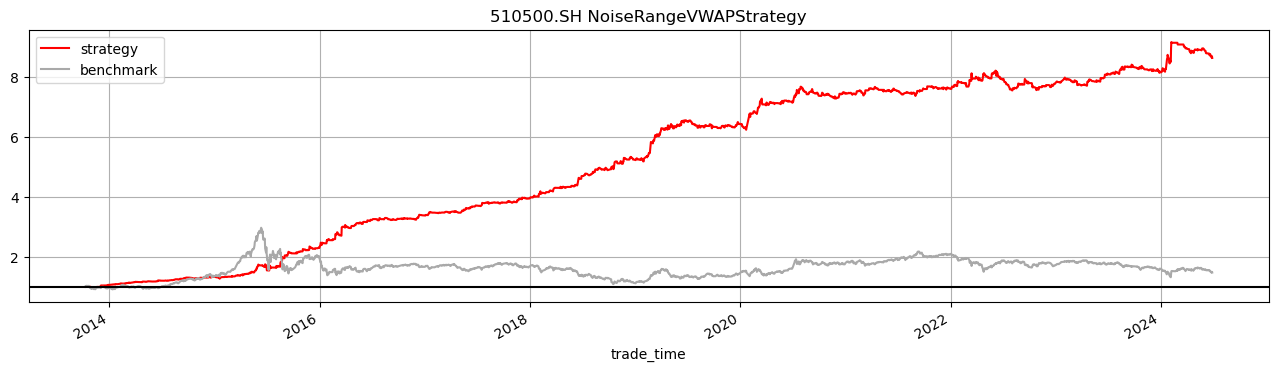

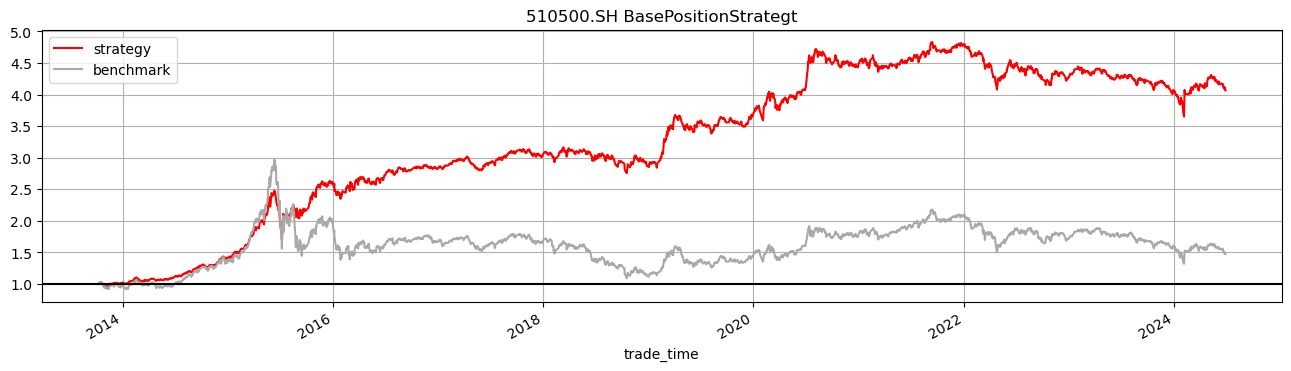

In [30]:
for strategy_name, strat in multi_strategy_dict[code].items():
    plot_cumulative_return(
        strat,
        combo_data.query("code==@code")["close"],
        title=f"{code} {strategy_name}",
    )

### 上证50ETF

In [33]:
code: str = "510050.SH"

multi_strategy_show_perf_stats(multi_strategy_dict[code],combo_data)

/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.548%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.707%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.898%' has dtype incompatible with floa

,NoiseRangeStrategy,NoiseRangeVWAPStrategy,BasePositionStrategt
,Backtest,Backtest,Backtest
Annual return,16.548%,7.707%,6.898%
Cumulative returns,385.177%,115.057%,98.97%
Annual volatility,13.337%,9.47%,12.926%
Sharpe ratio,1.215066,0.830933,0.580156
Calmar ratio,0.822596,0.577931,0.325186
Stability,0.964642,0.822307,0.787233
Max drawdown,-20.117%,-13.336%,-21.213%
Omega ratio,1.350879,1.267442,1.123363
Sortino ratio,1.948638,1.638877,1.005646


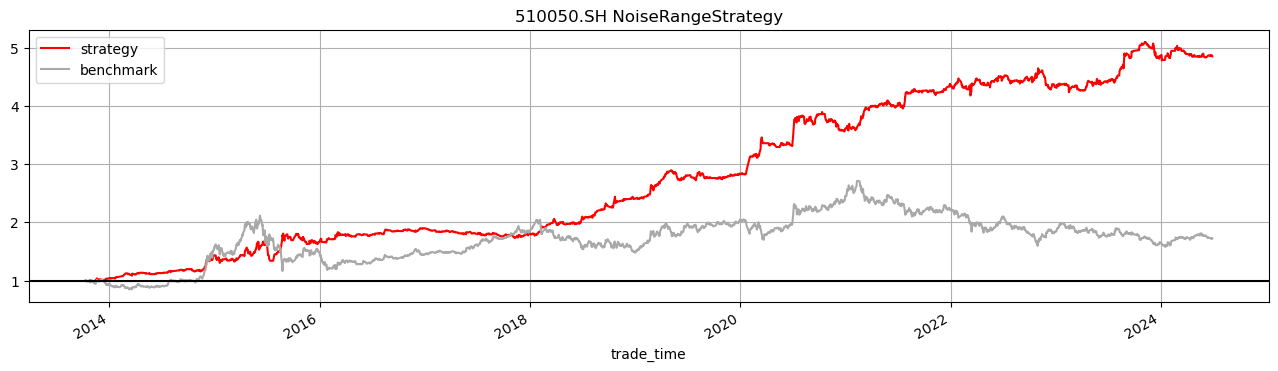

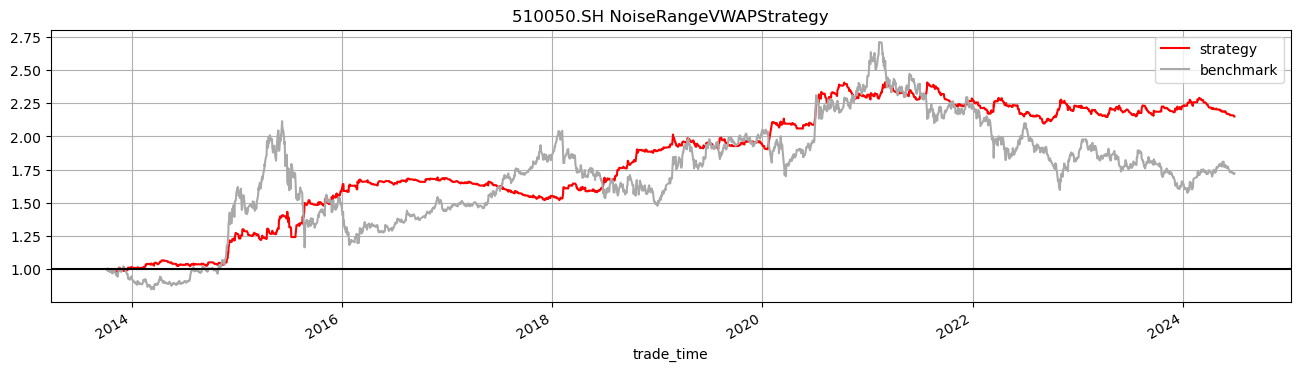

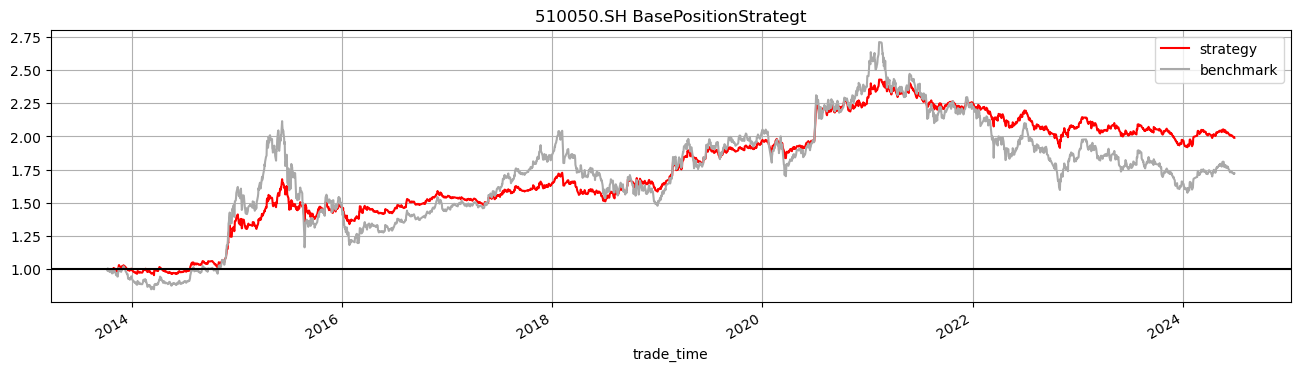

In [34]:

for strategy_name, strat in multi_strategy_dict[code].items():
    plot_cumulative_return(
        strat,
        combo_data.query("code==@code")["close"],
        title=f"{code} {strategy_name}",
    )

### 中证1000ETF

净值突然跳空是复权的原因

In [35]:
code:str = "159845.SZ"

multi_strategy_show_perf_stats(multi_strategy_dict[code],combo_data)

/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.676%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.115%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/root/miniconda3/envs/dev/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.602%' has dtype incompatible with flo

,NoiseRangeStrategy,NoiseRangeVWAPStrategy,BasePositionStrategt
,Backtest,Backtest,Backtest
Annual return,16.676%,15.115%,3.602%
Cumulative returns,61.876%,55.21%,11.687%
Annual volatility,12.227%,8.264%,11.561%
Sharpe ratio,1.322575,1.744641,0.36353
Calmar ratio,1.335866,1.476587,0.161611
Stability,0.718932,0.764195,0.000868
Max drawdown,-12.483%,-10.237%,-22.291%
Omega ratio,1.348184,1.526737,1.065495
Sortino ratio,2.055576,3.48503,0.594393


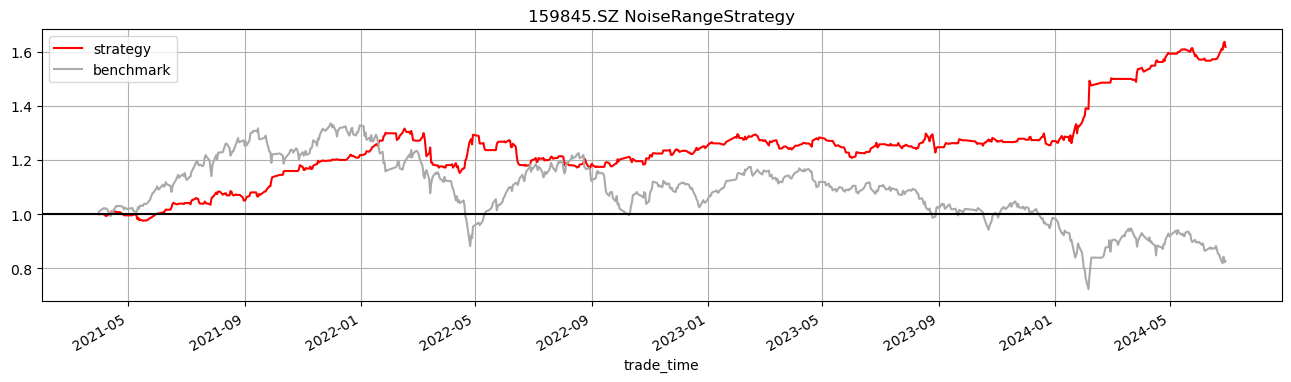

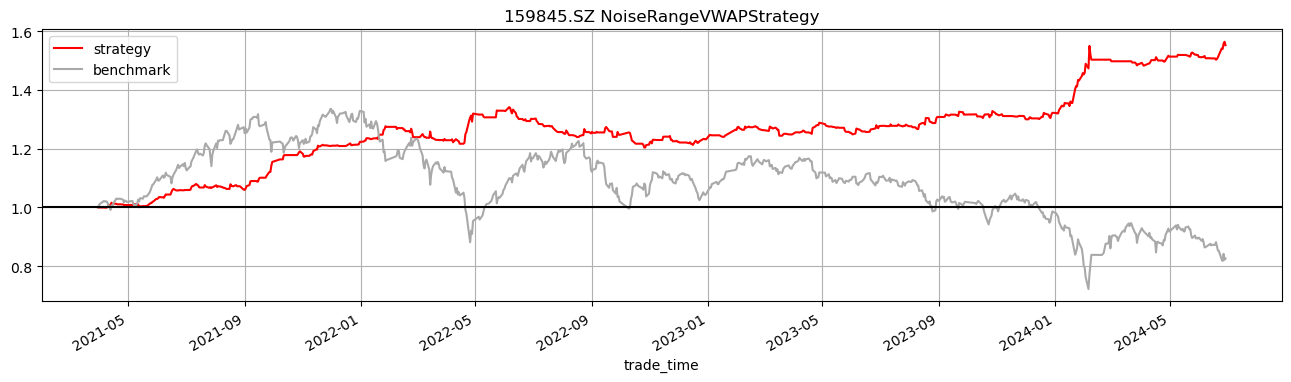

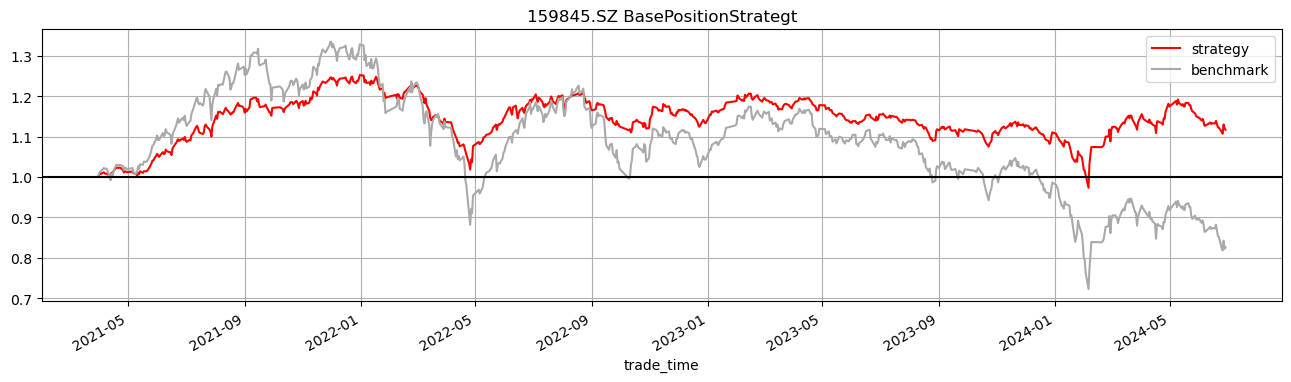

In [36]:

for strategy_name, strat in multi_strategy_dict[code].items():
    plot_cumulative_return(
        strat,
        combo_data.query("code==@code")["close"],
        title=f"{code} {strategy_name}",
    )